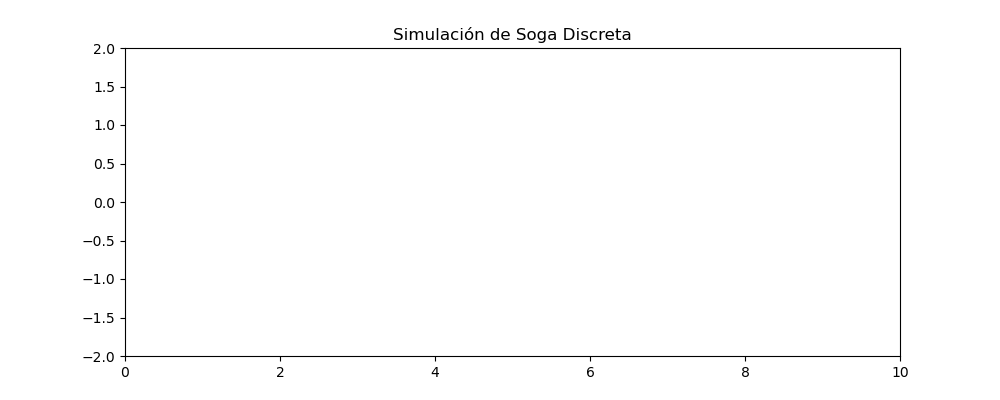

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
from scipy.integrate import solve_ivp
from IPython.display import display, clear_output

# ===== CONFIGURACIÓN =====
num_cuentas = 8
longitud_soga = 10.0
masa_cuenta = 1.0
masa_extremos = 1000.0
k_resorte = 10.0
dt = 0.05

# ===== ECUACIONES DIFERENCIALES =====
def ecuaciones_movimiento(t, y):
    pos = y[:num_cuentas*2].reshape(num_cuentas, 2)
    vel = y[num_cuentas*2:].reshape(num_cuentas, 2)
    
    fuerzas = np.zeros((num_cuentas, 2))
    for i in range(num_cuentas):
        if i > 0:
            fuerzas[i,1] -= k_resorte * (pos[i,1] - pos[i-1,1])
        if i < num_cuentas-1:
            fuerzas[i,1] -= k_resorte * (pos[i,1] - pos[i+1,1])
    
    masa = np.full(num_cuentas, masa_cuenta)
    masa[[0,-1]] = masa_extremos
    return np.concatenate([vel.ravel(), (fuerzas / masa[:,None]).ravel()])

# ===== INTERFAZ GRÁFICA =====
class Animador:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(10, 4))
        self.ax.set_xlim(0, longitud_soga)
        self.ax.set_ylim(-2, 2)
        self.ax.set_title("Simulación de Soga Discreta")
        
        # Elementos gráficos
        self.lineas = [self.ax.plot([],[], 'k-', lw=2)[0] for _ in range(num_cuentas-1)]
        self.puntos = self.ax.scatter([], [], s=100, color='blue', zorder=10)
        self.tiempo_txt = self.ax.text(0.02, 0.95, '', transform=self.ax.transAxes, fontsize=12)
        
        # Referencia persistente a la animación
        self.ani = None
    
    def actualizar_animacion(self, frame):
        pos = sol.y[:num_cuentas*2, frame].reshape(num_cuentas, 2)
        
        for j, linea in enumerate(self.lineas):
            x_vals = np.linspace(pos[j,0], pos[j+1,0], 20)
            y_base = np.interp(x_vals, [pos[j,0], pos[j+1,0]], [pos[j,1], pos[j+1,1]])
            y_vals = y_base + 0.1*np.sin(10*np.pi*(x_vals - pos[j,0])/(longitud_soga/(num_cuentas-1)))
            linea.set_data(x_vals, y_vals)
        
        self.puntos.set_offsets(pos)
        self.tiempo_txt.set_text(f'Tiempo: {sol.t[frame]:.2f} s')
        return self.lineas + [self.puntos, self.tiempo_txt]

# ===== WIDGETS Y CONTROL =====
animador = Animador()
controles_pos = [widgets.FloatSlider(min=-1, max=1, step=0.1, description=f'Pos {i+1}') for i in range(num_cuentas)]
controles_vel = [widgets.FloatSlider(min=-1, max=1, step=0.1, description=f'Vel {i+1}') for i in range(num_cuentas)]
boton = widgets.Button(description="▶️ Iniciar", button_style='success')
salida = widgets.Output()

def iniciar_simulacion(b):
    global sol
    with salida:
        clear_output(wait=True)
        
        # Condiciones iniciales
        pos = np.zeros((num_cuentas, 2))
        pos[:,0] = np.linspace(0, longitud_soga, num_cuentas)
        vel = np.zeros((num_cuentas, 2))
        
        for i in range(num_cuentas):
            pos[i,1] = controles_pos[i].value
            vel[i,1] = controles_vel[i].value
        
        # Resolver ecuaciones
        y0 = np.concatenate([pos.ravel(), vel.ravel()])
        sol = solve_ivp(ecuaciones_movimiento, [0, 20], y0, t_eval=np.arange(0, 20, dt))
        
        # Control de animación
        if animador.ani is not None:
            animador.ani.event_source.stop()
        
        animador.ani = animation.FuncAnimation(
            animador.fig,
            animador.actualizar_animacion,
            frames=len(sol.t),
            interval=dt*1000,
            blit=True
        )
        
        display(animador.fig.canvas)

# ===== DISEÑO FINAL =====
boton.on_click(iniciar_simulacion)
display(widgets.VBox([
    widgets.HTML("<h2 style='color: #2e86c1'>Controles</h2>"),
    widgets.GridBox(
        children=controles_pos + controles_vel + [boton],
        layout=widgets.Layout(grid_template_columns="repeat(4, 250px)")
    ),
    salida
]))